# A Tutorial for using Bandits for Travel Page Layout Optimization

- Robert F. Dickerson

Based on [An Efficient Bandit Algorithm for Realtime Multivariate Optimization](https://arxiv.org/pdf/1810.09558.pdf), Daniel Hill et. al. (Amazon.com) KDD'17

In [119]:
import pandas as pd
import random
import numpy as np

np.random.seed(42)

## Page layout problem

Suppose a web page has a static layout containing multiple slots to put content. 

- Slot 1 can contain a: 
    1. suit your style,
    2. map
    3. top rated
- Slot 2 can contain a: 
    1. city info
    2. weather
    3. pricing
- Slot 3 can contain a:
    1. reviews
    2. destination guide
    

### Example of widgets of Vrbo search page

View for example a [search page result for Barcelona](https://www.vrbo.com/vacation-rentals/europe/spain/catalunya/barcelona-province/barcelona)

It contains several widgets:

![widgets](pictures/vrbo-widgets.png)

Maybe there are some (pair-wise) interactions where placing the weather widget and the year pricing widget on the page at the same time boosts the chance of a reward more than the sum of its parts.

In this case, the number of potential layouts, $A$, are $3 \times 3 \times 2 = 18$

If we assume each slot can contain $N$ types of content, and there are $D$ slots then there are $N^D$ potential layouts. Quickly becomes a **combinatorial explosion!**

We can add context, $X$, such as time of year or user history so that perhaps certain widgets should be presented more often based on a user's viewing habit.

A feature vector can be formed $B_{A, X}$ combining layout and context.

Let's assume that a reward, $R$, could be that a booking was eventually made. $R \in \{-1, 1\}$

We can store the history $H_t$ of all the layouts users have seen as a tuple, $(A_t, X_t, R_t)$. 

## Generate random simulated data

Let's generate artificially some random combinations of content and assign the value for reward:

- If reviews is in slot 3 then a booking is $p=0.4$ likely.
- But if reviews is in slot 3 and top rated rentals are shown in slot 1 then a booking is $p=0.7$ likely.
- In all other cases, bookings are $p=0.2$ likely

This is highly simplistic example, but it does allow us to represent randomness with a Bernoulli trial. Every time we expose a user to a page layout we draw a random sample that is binary. It demonstrates interaction effects as well.




In [120]:
choices_slot_1 = ["suit_style", "map", "top_rated"]
choices_slot_2 = ["city_info", "weather", "pricing"]
choices_slot_3 = ["reviews", "destination_guide"]

# number of random layouts to generate
N = 1000


s1 = random.choices(choices_slot_1, k=N)
s2 = random.choices(choices_slot_2, k=N)
s3 = random.choices(choices_slot_3, k=N)


def is_reward(s1, s2, s3):
    
    # draw a uniform random sample
    r = np.random.random()
    
    p = 0.2
    
    if s3 == 'reviews':
        p = 0.4
        if s1 == 'top_rated':
            p = 0.7
    
    return 1 if r > p else -1
    

data = {'slot1': s1, 'slot2': s2, 'slot3': s3, 'location_context': 'US'}
df = pd.DataFrame(data=data)
df['reward'] = df.apply(lambda x: is_reward(x['slot1'], x['slot2'], x['slot3']), axis=1)

display(df)

,slot1,slot2,slot3,location_context,reward
0,top_rated,weather,reviews,US,-1
1,suit_style,pricing,reviews,US,1
2,map,weather,destination_guide,US,1
3,map,weather,destination_guide,US,1
4,map,weather,destination_guide,US,-1
...,...,...,...,...,...
995,map,pricing,destination_guide,US,-1
996,map,pricing,reviews,US,1
997,map,weather,destination_guide,US,-1
998,top_rated,pricing,destination_guide,US,1


In [281]:
def feature_vector(slot1, slot2, slot3):
    """Creates a one-hot binary vector based on the layout"""
    s1 = choices_slot_1.index(slot1)
    s2 = choices_slot_2.index(slot2)
    s3 = choices_slot_3.index(slot3)
    
    sx1 = len(choices_slot_1)
    sx2 = len(choices_slot_2)
    sx3 = len(choices_slot_3)
    
    a = np.zeros(sx1 + sx2 + sx3)
    
    offset = 0
    a[s1 + offset] = 1
    offset += sx1
    a[s2 + offset] = 1
    offset += sx2
    a[s3 + offset] = 1
    offset += sx3
    
    return a
    
def describe_features(features):
    for i, value in enumerate(choices_slot_1):
        if features[i]:
            print(value)
            
    for i, value in enumerate(choices_slot_2):
        if features[i+3]:
            print(value)
            
    for i, value in enumerate(choices_slot_3):
        if features[i+6]:
            print(value)
        
    
    
df['feature'] = df.apply(lambda x: feature_vector(x['slot1'], x['slot2'], x['slot3']), axis=1)

display(df)

describe_features(df['feature'].iloc[1])

,slot1,slot2,slot3,location_context,reward,feature
0,top_rated,weather,reviews,US,-1,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
1,suit_style,pricing,reviews,US,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
2,map,weather,destination_guide,US,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
3,map,weather,destination_guide,US,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
4,map,weather,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
...,...,...,...,...,...,...
995,map,pricing,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
996,map,pricing,reviews,US,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
997,map,weather,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
998,top_rated,pricing,destination_guide,US,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]"


suit_style
pricing
reviews


## Online Learning

Refer to [Web-scale Bayesian Click-Through Rate Prediction for Sponsored Search Advertizing in Microsoft's Bing Search Engine]() Thore Graepel, et. al. (Microsoft.com), ICML 2010

$p(y | x, W)$


total variance:

$\Sigma^2 = \beta^2 + x^T*\sigma^2$

Update the posterior values:

$\mu := \mu + y x * \frac{\sigma^2}{\Sigma} \cdot v(\frac{y \cdot x^T\mu}{\Sigma})$

$\sigma^2 := \sigma^2 \cdot [1 - x \cdot \frac{\sigma^2}{\Sigma^2} \cdot w(\frac{y \cdot x^T\mu}{\Sigma}]$

$v(t) = \frac{\mathcal{N}(t; 0, 1)}{\Phi(t; 0, 1)}$

$w(t) = v(t) \cdot [v(t) + t]$

In [215]:

from scipy.stats import norm, bernoulli

d = 8
t = 10

mu = np.zeros(d)
sigma = np.ones(d)

def v(t):
    return norm.pdf(t)/norm.cdf(t)

def w(t):
    return v(t) * (v(t) + t)

def update(mu, sigma, feature, reward, beta=1):
    
    variance = beta**2 + feature*sigma
    Sigma = np.sqrt(variance)
        
    mu = mu + reward * feature * sigma**2/Sigma * v(reward*feature*mu/Sigma)
    sigma = sigma * (1 - feature * sigma**2/Sigma * w(reward * feature * mu/Sigma))
    return mu, sigma

for i in range(t):
    row = df.iloc[i]
    feature = row['feature']
    reward = row['reward']
    
    mu, sigma = update(mu, sigma, feature, reward)
    

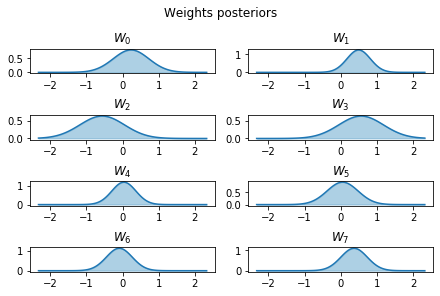

In [216]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 2, constrained_layout=True)
fig.suptitle("Weights posteriors")

for i in range(d):

    x = np.linspace(norm.ppf(0.01), norm.ppf(0.99), 100)

    y = norm.pdf(x, loc=mu[i], scale=sigma[i])

    ri = i//2
    ci = i%2
    axs[ri, ci].plot(x, y, label=str(i))
    axs[ri, ci].fill_between(x, 0, y, color="#348ABD", alpha=0.4)
    axs[ri, ci].set_title(r'$W_{}$'.format(i))


plt.show()

## Thompson Sampling

solve $\arg \max_A B^T_{A, X} W$

- for all $t = 1, \ldots, T$ do
    - receive context $X_t$
    - sample $W_T$ from the posterior $P(W|H_{t-1})$
    - select $A_t = \arg \max_A B^T_{A, X_t} W_t$
    - display layout $A_t$ and observe reward $R_t$
    - update $H_t = H_{t-1} \cup (A_t, R_t, X_t)$

In [227]:
w_tilde = np.random.normal(mu, sigma)

b1 = feature_vector('top_rated', 'pricing', 'reviews')
b2 = feature_vector('top_rated', 'pricing', 'destination_guide')
b3 = feature_vector('suit_style', 'city_info', 'destination_guide')

#b = [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0]

c1 = np.sum(b1*w_tilde)
c2 = np.sum(b2*w_tilde)
c3 = np.sum(b3*w_tilde)

print(norm.cdf(c1))
print(norm.cdf(c2))
print(norm.cdf(c3))

norm.cdf([c1, c2])

0.19033128003009114
0.3460389160521523
0.9948228434635226


array([0.19033128, 0.34603892])

In [131]:
df

,slot1,slot2,slot3,location_context,reward,feature
0,top_rated,weather,reviews,US,-1,"[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
1,suit_style,pricing,reviews,US,1,"[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
2,map,weather,destination_guide,US,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
3,map,weather,destination_guide,US,1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
4,map,weather,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
...,...,...,...,...,...,...
995,map,pricing,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0]"
996,map,pricing,reviews,US,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0]"
997,map,weather,destination_guide,US,-1,"[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0]"
998,top_rated,pricing,destination_guide,US,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]"


In [283]:
import itertools

b = itertools.product(choices_slot_1, choices_slot_2, choices_slot_3)

c = [feature_vector(*x) for x in b]

B = np.row_stack(c)
print("Search space: \n {}".format(space))

s = np.sum(w_tilde * B, axis=1)
s = norm.cdf(s)
print("Probability of reward")
print(s)

best = np.argmin(s)
print(B[best])

describe_features(B[best])

Search space: 
 [[1. 0. 0. 1. 0. 0. 1. 0.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 1. 0.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]]
Probability of reward
[0.98138019 0.99482284 0.43097682 0.62048373 0.43059828 0.62011701
 0.99228078 0.99814941 0.56549347 0.74071508 0.5651143  0.74040294
 0.916407   0.96869435 0.1905931  0.34639433 0.19033128 0.34603892]
[0. 0. 1. 0. 0. 1. 1. 0.]
top_rated
pricing
reviews


In [273]:
[int(x) for x in bin(10)[2:]]

[1, 0, 1, 0]